In [ ]:
# This Jupyter notebook is used to plot Figure 10,11,12 in Model 3
# 论文中模型3中的图10、11、12都是使用下面代码绘制出来的
# 但这里的代码绘制并不能完全复现论文中的图片，因为之前的参数我忘记保存了，现在整理的时候找不到之前那一版代码了。不过代码内容应该都一样，只是参数不同
# 尝试修改下面代码中的参数就可以绘制不同的图像，这就是所谓的“调参”（或者说“炼丹”（笑
# 在比赛中需要通过调参最终挑出一版放在论文中好看的图像（最终放在论文里的图像中展现的结果要服务于论文中的叙述逻辑，图像要以能够解释论文结论为主要目标）

import numpy as np
import matplotlib.pyplot as plt

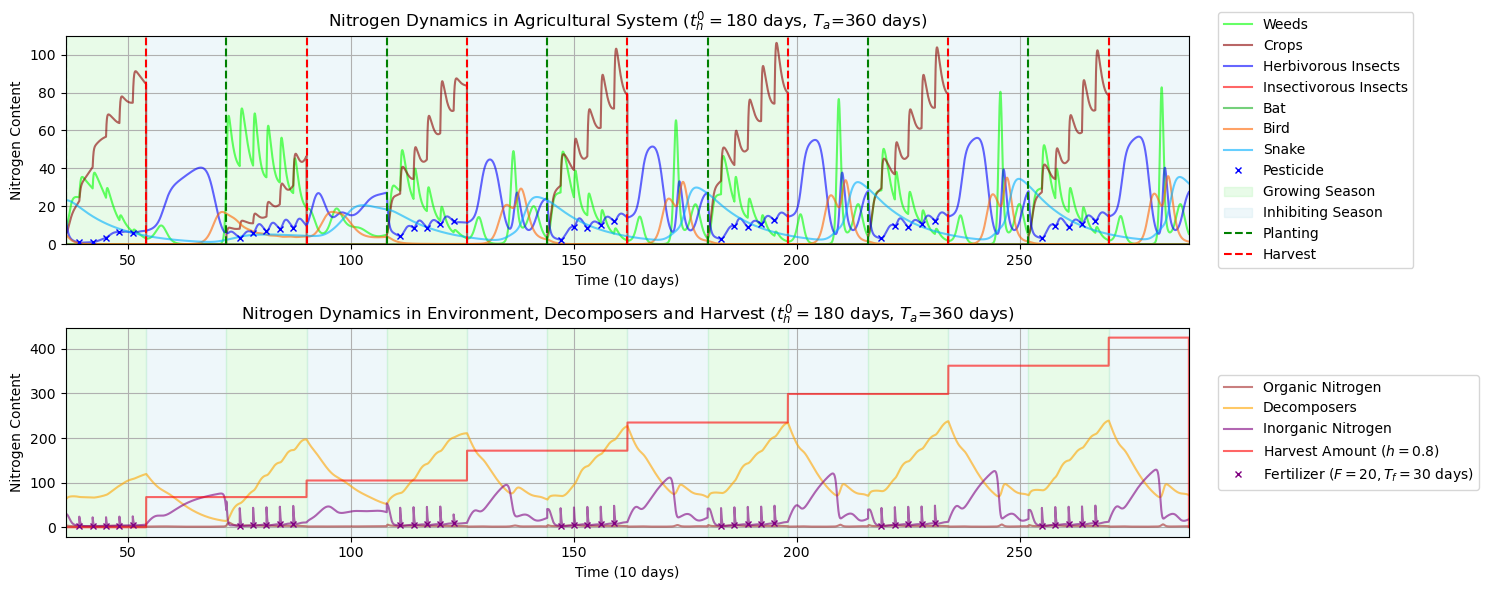

In [1]:
# Agricultural parameters
T_a = 36  # agricultural cycle
t_h_0 = 18  # initial harvest time
t_s_0 = 0  # initial planting time
S = 5     # seeding amount
h = 0.8    # harvest coefficient

# Chemical parameters
gamma_w_chem = 1.5    # herbicide effect
lambda_w = 0.05        # herbicide decay rate
T_w = 300000             # herbicide application period 除草周期
gamma_1_chem = 2   # pesticide effect
lambda_1 = 0.04        # pesticide decay rate 
T_1 = 3             # pesticide application period 杀虫周期

# Fertilizer parameters
F = 20               # fertilizer amount
T_f = 3            # fertilizer period
t_f_0 = 0           # initial fertilizer time

# Parameters for seasonal variation
T = 36  # period (12 months)
phi = 0  # phase shift
r_w_0 = 0.07  # baseline growth rate of weeds
r_w_season = 0.035  # seasonal amplitude for weeds
r_c_0 = 0.05  # baseline growth rate of crops
r_c_season = 0.02  # seasonal amplitude for crops
gamma_1_0 = 0.02  # baseline death rate for primary consumers
gamma_1_season = 0.067  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.067  # baseline death rate for weeds
gamma_w_season = 0.05  # seasonal amplitude for weed death rate
gamma_c_0 = 0.03  # baseline death rate for crops
gamma_c_season = 0.015  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
gamma = np.array([gamma_1_0, 0.5, 0.3, 0.2, 0.1])  # initial death rates for consumers
alpha_w1 = 0.08
alpha_c1 = 0.04
alpha = np.array([0.05])
beta_w1 = 0.04
beta_c1 = 0.02
beta = np.array([0.04])
c_wc = 0.0002
c_cw = 0.0005
d = 0.2
delta = 0.12
gamma_D = 0.30


# Time parameters
t_max = 288
dt = 0.005
t = np.arange(0, t_max, dt)
n_steps = len(t)

prey_matrix = np.array([[0,1,1,1,0], [0,0,1,1,0], [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,0]])
alpha_matrix = np.array([[0, 0.04, 0.04 ,0.04 ,0], [0 ,0 ,0.03 ,0.03 ,0], [0, 0, 0, 0, 0.03], [0, 0, 0, 0, 0.03], [0,0,0,0,0]])
beta_matrix = np.array([[0, 0.03, 0.03 ,0.03 ,0], [0 ,0 ,0.02 ,0.02 ,0], [0, 0, 0, 0, 0.02], [0, 0, 0, 0, 0.02], [0,0,0,0,0]])


# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((5, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)
# Initialize arrays
harvest = np.zeros(n_steps)  # Store harvest amount at each time point
last_harvest_time = -float('inf')  # Track the last harvest time
have_harvest = np.zeros(n_steps)  # Store harvest at each time point

# Initial conditions (same as before)
N_w[0] = 10
N_c[0] = 15
N[:, 0] = [4, 4, 4, 4, 3]
N_org[0] = 5
N_D[0] = 150
N_inorg[0] = 20

# Define time-varying parameter functions
def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t):
    return r_c_0 + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)


def gamma_w(t):
    n_w = int(t/T_w)  # Current herbicide cycle
    if(N_c[i] > 0):
        return (gamma_w_0 + 
                gamma_w_chem * np.exp(-lambda_w * (t - T_w*n_w)) +
                gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi))
    else:
        return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    n_1 = int(t/T_1)  # Current pesticide cycle
    if(N_c[i] > 0):
        return (gamma_1_0 + 
            gamma_1_chem * np.exp(-lambda_1 * (t - T_1*n_1)) +
            gamma_1_season * np.sin(2*np.pi*t/T + phi))
    else:
        return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi)




# Modified simulation loop
for i in range(n_steps-1):
    n_a = int(t[i]/T_a)  # Current agricultural cycle

    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1], gamma[2], gamma[3], gamma[4]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Calculate predation and consumption terms using matrices
    for j in range(5):  # j is predator
        # Calculate predation loss
        predation_loss = np.sum((prey_matrix[j,:] * alpha_matrix[j,:]) * N[:,i]) * N[j,i]
        # Calculate consumption gain
        consumption_gain = np.sum((prey_matrix[:,j] * beta_matrix[:,j]) * N[:,i]) * N[j,i]
        # Update population
        N[j,i+1] = N[j,i] + dt * (-predation_loss + consumption_gain - current_gamma[j] * N[j,i])

    N[0,i+1] += dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i])
    

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i]) * N_inorg[i] * N_c[i])
    
 # Add fertilizer
    n_f = int(t[i]/T_f)
    if abs(t[i] - (t_f_0 + T_f*n_f)) < dt:
        if (N_c[i] > 0):
            N_inorg[i+1] += F


    # Harvest time
    if abs(t[i] - (t_h_0 + T_a*n_a)) < dt and N_c[i] > 0:
        harvest[i] = h * N_c[i+1] + harvest[i-1] # Store the harvest amount
        N_c[i+1] = 0  # Remove crops after harvest
    else:
        harvest[i] = harvest[i-1]  # Maintain harvest amount after harvest time

    if n_a == 0:
        harvest[i] = 0

    # Planting time with smooth transition
    if (abs(t[i] - (t_s_0 + T_a*n_a)) < dt):
        # Only plant if there are no crops
        if N_c[i] < 0.1:  # Small threshold to check if field is empty
            N_c[i+1] = S
        else:
            N_c[i+1] = N_c[i]  # Maintain current crop level if already planted
        

# Plot results
plt.figure(figsize=(15, 6))

# First subplot: Population dynamics
plt.subplot(2, 1, 1)
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.ylim(0, 110)  # Limit x-axis to actual data range
plt.plot(t, N_w, label='Weeds', color='lime', alpha=0.6)
plt.plot(t, N_c, label='Crops', color='darkred', alpha=0.6)
plt.plot(t, N[0], label='Herbivorous Insects', color='blue', alpha=0.6)
plt.plot(t, N[1], label='Insectivorous Insects', color='red', alpha=0.6)
plt.plot(t, N[2], label='Bat', color='#1ab223', alpha=0.6)
plt.plot(t, N[3], label='Bird', color='#ff6500', alpha=0.6)
plt.plot(t, N[4], label='Snake', color='#00b0ff', alpha=0.6)

# Add markers for herbicide application
for i in range(int(t_max/T_w)):
    if N_c[int(i*T_w/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_w, N_w[int(i*T_w/dt)], '^', color='lime', markersize=5, 
                label='Herbicide' if i==0 else "")

# Add markers for pesticide application
for i in range(int(t_max/T_1)):
    if N_c[int(i*T_1/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_1, N[0,int(i*T_1/dt)], 'x', color='blue', markersize=5, 
                label='Pesticide' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, 
                label='Growing Season' if i==0 else "")
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, 
                label='Inhibiting Season' if i==0 else "")
                
# Add markers for agricultural operations
for i in range(int(t_max/T_a)):
    # Planting time markers
    plt.axvline(x=t_s_0 + i*T_a, color='green', linestyle='--', 
                label='Planting' if i==0 else "")
    # Harvest time markers
    plt.axvline(x=t_h_0 + i*T_a, color='red', linestyle='--', 
                label='Harvest' if i==0 else "")

# Enable mathtext
plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Plot and set title with mathtext
plt.title(r'Nitrogen Dynamics in Agricultural System ($t_h^{0}=180$ days, $T_a$=360 days)')

# plt.title('Nitrogen Dynamics in Agricultural System ()')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)

# Second subplot: Nitrogen dynamics
plt.subplot(2, 1, 2)
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_org, label='Organic Nitrogen', color='brown', alpha=0.6)
plt.plot(t, N_D, label='Decomposers', color='orange', alpha=0.6)
plt.plot(t, N_inorg, label='Inorganic Nitrogen', color='purple', alpha=0.6)
plt.plot(t, harvest, label=r'Harvest Amount ($h = 0.8$)', color='red', alpha=0.6)

# Add markers for fertilizer application
for i in range(int(t_max/T_f)):
    if N_c[int(i*T_f/dt)] > 0:  # Only show markers when crops exist
        plt.plot(i*T_f, N_inorg[int(i*T_f/dt)], 'x', color='purple', markersize=5, 
                label=r'Fertilizer ($F = 20, T_f = 30$ days)' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2)
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2)

plt.title(r'Nitrogen Dynamics in Environment, Decomposers and Harvest ($t_h^{0}=180$ days, $T_a$=360 days)')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)

plt.tight_layout()
plt.show()


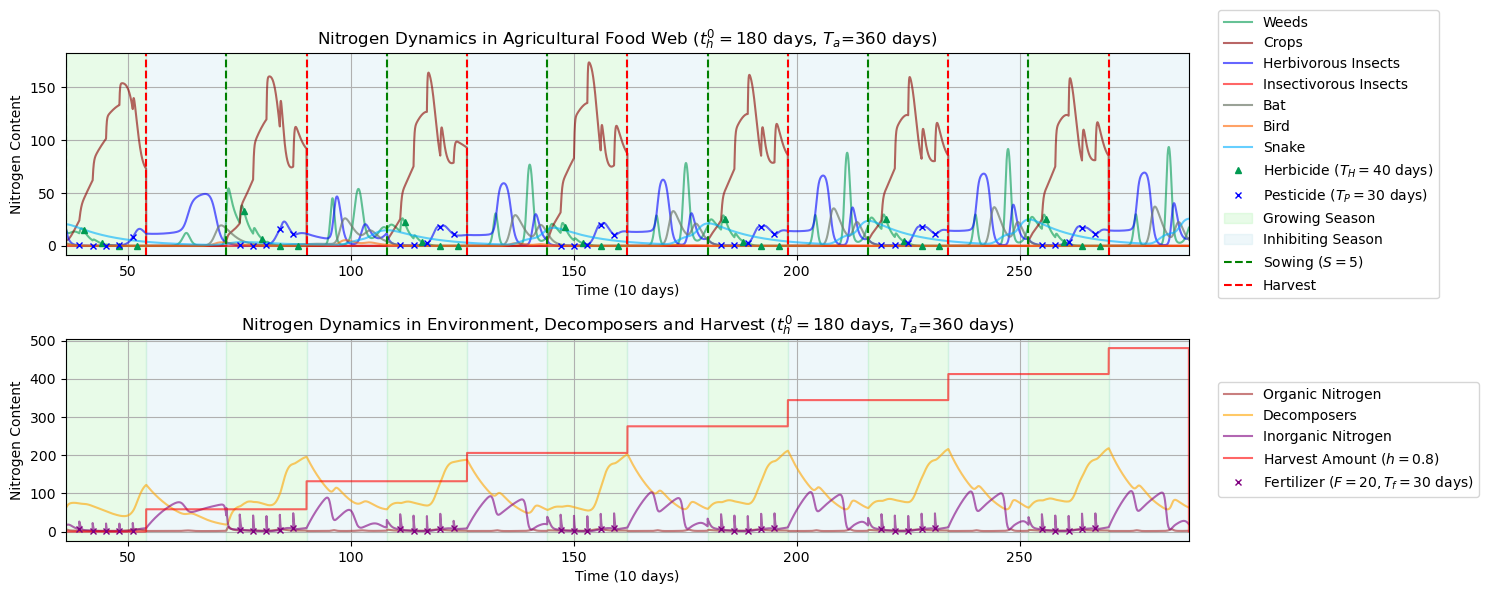

In [2]:
# 加除草剂
import numpy as np
import matplotlib.pyplot as plt

# New parameters
# Agricultural parameters
T_a = 36  # agricultural cycle
t_h_0 = 18  # initial harvest time
t_s_0 = 0  # initial planting time
S = 5     # seeding amount
h = 0.8    # harvest coefficient

# Chemical parameters
gamma_w_chem = 0.8    # herbicide effect
lambda_w = 0.06        # herbicide decay rate
T_w = 4             # herbicide application period 除草周期
gamma_1_chem = 2   # pesticide effect
lambda_1 = 0.04        # pesticide decay rate 
T_1 = 3             # pesticide application period 杀虫周期

# Fertilizer parameters
F = 20               # fertilizer amount
T_f = 3            # fertilizer period
t_f_0 = 0           # initial fertilizer time

# Parameters for seasonal variation
T = 36  # period (12 months)
phi = 0  # phase shift
r_w_0 = 0.07  # baseline growth rate of weeds
r_w_season = 0.035  # seasonal amplitude for weeds
r_c_0 = 0.05  # baseline growth rate of crops
r_c_season = 0.02  # seasonal amplitude for crops
gamma_1_0 = 0.02  # baseline death rate for primary consumers
gamma_1_season = 0.067  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.067  # baseline death rate for weeds
gamma_w_season = 0.05  # seasonal amplitude for weed death rate
gamma_c_0 = 0.03  # baseline death rate for crops
gamma_c_season = 0.015  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
gamma = np.array([gamma_1_0, 0.5, 0.3, 0.2, 0.1])  # initial death rates for consumers
alpha_w1 = 0.08
alpha_c1 = 0.04
alpha = np.array([0.05])
beta_w1 = 0.04
beta_c1 = 0.02
beta = np.array([0.04])
c_wc = 0.0002
c_cw = 0.0005
d = 0.2
delta = 0.12
gamma_D = 0.30


# Time parameters
t_max = 288
dt = 0.005
t = np.arange(0, t_max, dt)
n_steps = len(t)

prey_matrix = np.array([[0,1,1,1,0], [0,0,1,1,0], [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,0]])
alpha_matrix = np.array([[0, 0.04, 0.05 ,0.04 ,0], [0 ,0 ,0.04 ,0.03 ,0], [0, 0, 0, 0, 0.03], [0, 0, 0, 0, 0.03], [0,0,0,0,0]])
beta_matrix = np.array([[0, 0.03, 0.04 ,0.03 ,0], [0 ,0 ,0.03 ,0.02 ,0], [0, 0, 0, 0, 0.02], [0, 0, 0, 0, 0.02], [0,0,0,0,0]])


# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((5, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)
# Initialize arrays
harvest = np.zeros(n_steps)  # Store harvest amount at each time point
last_harvest_time = -float('inf')  # Track the last harvest time
have_harvest = np.zeros(n_steps)  # Store harvest at each time point

# Initial conditions (same as before)
N_w[0] = 10
N_c[0] = 15
N[:, 0] = [4, 4, 4, 4, 3]
N_org[0] = 5
N_D[0] = 150
N_inorg[0] = 20

# Define time-varying parameter functions
def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t):
    return r_c_0 + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)


def gamma_w(t):
    n_w = int(t/T_w)  # Current herbicide cycle
    if(N_c[i] > 0):
        return (gamma_w_0 + 
                gamma_w_chem * np.exp(-lambda_w * (t - T_w*n_w)) +
                gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi))
    else:
        return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    n_1 = int(t/T_1)  # Current pesticide cycle
    if(N_c[i] > 0):
        return (gamma_1_0 + 
            gamma_1_chem * np.exp(-lambda_1 * (t - T_1*n_1)) +
            gamma_1_season * np.sin(2*np.pi*t/T + phi))
    else:
        return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi)




# Modified simulation loop
for i in range(n_steps-1):
    n_a = int(t[i]/T_a)  # Current agricultural cycle

    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1], gamma[2], gamma[3], gamma[4]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Calculate predation and consumption terms using matrices
    for j in range(5):  # j is predator
        # Calculate predation loss
        predation_loss = np.sum((prey_matrix[j,:] * alpha_matrix[j,:]) * N[:,i]) * N[j,i]
        # Calculate consumption gain
        consumption_gain = np.sum((prey_matrix[:,j] * beta_matrix[:,j]) * N[:,i]) * N[j,i]
        # Update population
        N[j,i+1] = N[j,i] + dt * (-predation_loss + consumption_gain - current_gamma[j] * N[j,i])

    N[0,i+1] += dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i])
    

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i]) * N_inorg[i] * N_c[i])
    
 # Add fertilizer
    n_f = int(t[i]/T_f)
    if abs(t[i] - (t_f_0 + T_f*n_f)) < dt:
        if (N_c[i] > 0):
            N_inorg[i+1] += F


    # Harvest time
    if abs(t[i] - (t_h_0 + T_a*n_a)) < dt and N_c[i] > 0:
        harvest[i] = h * N_c[i+1] + harvest[i-1] # Store the harvest amount
        N_c[i+1] = 0  # Remove crops after harvest
    else:
        harvest[i] = harvest[i-1]  # Maintain harvest amount after harvest time

    if n_a == 0:
        harvest[i] = 0

    # Planting time with smooth transition
    if (abs(t[i] - (t_s_0 + T_a*n_a)) < dt):
        # Only plant if there are no crops
        if N_c[i] < 0.1:  # Small threshold to check if field is empty
            N_c[i+1] = S
        else:
            N_c[i+1] = N_c[i]  # Maintain current crop level if already planted
        

# Plot results
plt.figure(figsize=(15, 6))

# First subplot: Population dynamics
plt.subplot(2, 1, 1)
plt.xlim(36, t_max)  # Limit x-axis to actual data range
#plt.ylim(0, 180)  # Limit x-axis to actual data range
plt.plot(t, N_w, label='Weeds', color='#009a51', alpha=0.6)
plt.plot(t, N_c, label='Crops', color='darkred', alpha=0.6)
plt.plot(t, N[0], label='Herbivorous Insects', color='blue', alpha=0.6)
plt.plot(t, N[1], label='Insectivorous Insects', color='red', alpha=0.6)
plt.plot(t, N[2], label='Bat', color='#6f7b6b', alpha=0.7)
plt.plot(t, N[3], label='Bird', color='#ff6500', alpha=0.6)
plt.plot(t, N[4], label='Snake', color='#00b0ff', alpha=0.6)

# Add markers for herbicide application
for i in range(int(t_max/T_w)):
    if N_c[int(i*T_w/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_w, N_w[int(i*T_w/dt)], '^', color='#009a51', markersize=5, 
                label=r'Herbicide ($T_H = 40$ days)' if i==0 else "")

# Add markers for pesticide application
for i in range(int(t_max/T_1)):
    if N_c[int(i*T_1/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_1, N[0,int(i*T_1/dt)], 'x', color='blue', markersize=5, 
                label='Pesticide ($T_P = 30$ days)' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, 
                label='Growing Season' if i==0 else "")
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, 
                label='Inhibiting Season' if i==0 else "")
                
# Add markers for agricultural operations
for i in range(int(t_max/T_a)):
    # Planting time markers
    plt.axvline(x=t_s_0 + i*T_a, color='green', linestyle='--', 
                label=r'Sowing ($S = 5$)' if i==0 else "")
    # Harvest time markers
    plt.axvline(x=t_h_0 + i*T_a, color='red', linestyle='--', 
                label='Harvest' if i==0 else "")

# Enable mathtext
plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Plot and set title with mathtext
plt.title(r'Nitrogen Dynamics in Agricultural Food Web ($t_h^{0}=180$ days, $T_a$=360 days)')

# plt.title('Nitrogen Dynamics in Agricultural System ()')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)

# Second subplot: Nitrogen dynamics
plt.subplot(2, 1, 2)
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_org, label='Organic Nitrogen', color='brown', alpha=0.6)
plt.plot(t, N_D, label='Decomposers', color='orange', alpha=0.6)
plt.plot(t, N_inorg, label='Inorganic Nitrogen', color='purple', alpha=0.6)
plt.plot(t, harvest, label=r'Harvest Amount ($h = 0.8$)', color='red', alpha=0.6)

# Add markers for fertilizer application
for i in range(int(t_max/T_f)):
    if N_c[int(i*T_f/dt)] > 0:  # Only show markers when crops exist
        plt.plot(i*T_f, N_inorg[int(i*T_f/dt)], 'x', color='purple', markersize=5, 
                label=r'Fertilizer ($F = 20, T_f = 30$ days)' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2)
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2)

plt.title(r'Nitrogen Dynamics in Environment, Decomposers and Harvest ($t_h^{0}=180$ days, $T_a$=360 days)')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)

plt.tight_layout()
plt.show()


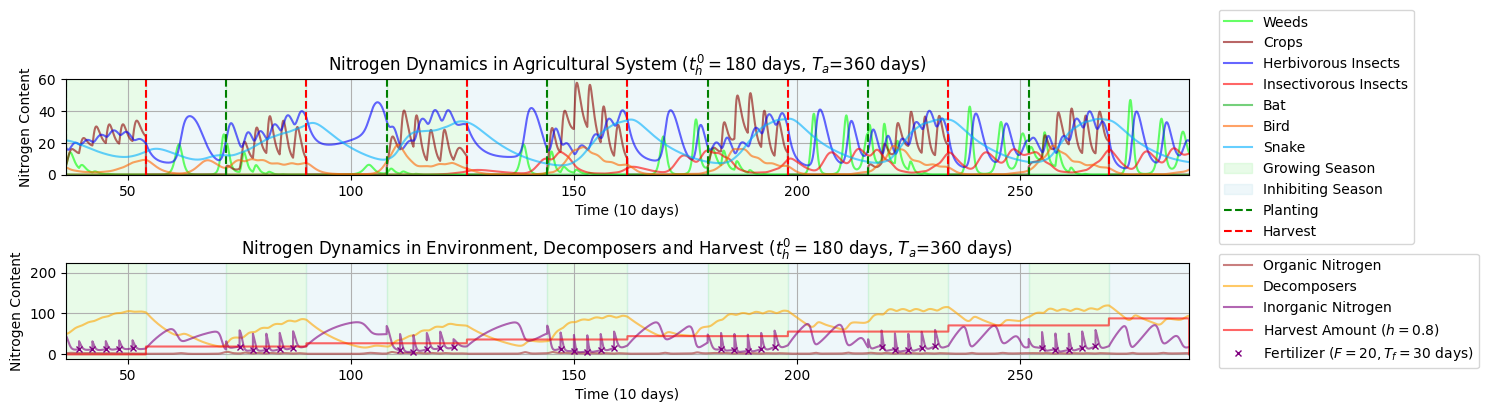

In [43]:
# 无除草剂无杀虫剂
import numpy as np
import matplotlib.pyplot as plt

# New parameters
# Agricultural parameters
T_a = 36  # agricultural cycle
t_h_0 = 18  # initial harvest time
t_s_0 = 0  # initial planting time
S = 5     # seeding amount
h = 0.8    # harvest coefficient

# Chemical parameters
gamma_w_chem = 0.8    # herbicide effect
lambda_w = 0.06        # herbicide decay rate
T_w = 4000             # herbicide application period 除草周期
gamma_1_chem = 2   # pesticide effect
lambda_1 = 0.04        # pesticide decay rate 
T_1 = 3000            # pesticide application period 杀虫周期

# Fertilizer parameters
F = 20               # fertilizer amount
T_f = 3            # fertilizer period
t_f_0 = 0           # initial fertilizer time

# Parameters for seasonal variation
T = 36  # period (12 months)
phi = 0  # phase shift
r_w_0 = 0.07  # baseline growth rate of weeds
r_w_season = 0.035  # seasonal amplitude for weeds
r_c_0 = 0.05  # baseline growth rate of crops
r_c_season = 0.02  # seasonal amplitude for crops
gamma_1_0 = 0.02  # baseline death rate for primary consumers
gamma_1_season = 0.067  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.067  # baseline death rate for weeds
gamma_w_season = 0.05  # seasonal amplitude for weed death rate
gamma_c_0 = 0.03  # baseline death rate for crops
gamma_c_season = 0.015  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
gamma = np.array([gamma_1_0, 0.5, 0.3, 0.2, 0.1])  # initial death rates for consumers
alpha_w1 = 0.08
alpha_c1 = 0.04
alpha = np.array([0.05])
beta_w1 = 0.04
beta_c1 = 0.02
beta = np.array([0.04])
c_wc = 0.0002
c_cw = 0.0005
d = 0.2
delta = 0.12
gamma_D = 0.30


# Time parameters
t_max = 288
dt = 0.005
t = np.arange(0, t_max, dt)
n_steps = len(t)

prey_matrix = np.array([[0,1,1,1,0], [0,0,1,1,0], [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,0]])
alpha_matrix = np.array([[0, 0.04, 0.04 ,0.04 ,0], [0 ,0 ,0.03 ,0.03 ,0], [0, 0, 0, 0, 0.03], [0, 0, 0, 0, 0.03], [0,0,0,0,0]])
beta_matrix = np.array([[0, 0.03, 0.03 ,0.03 ,0], [0 ,0 ,0.02 ,0.02 ,0], [0, 0, 0, 0, 0.02], [0, 0, 0, 0, 0.02], [0,0,0,0,0]])


# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((5, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)
# Initialize arrays
harvest = np.zeros(n_steps)  # Store harvest amount at each time point
last_harvest_time = -float('inf')  # Track the last harvest time
have_harvest = np.zeros(n_steps)  # Store harvest at each time point

# Initial conditions (same as before)
N_w[0] = 10
N_c[0] = 15
N[:, 0] = [4, 4, 4, 4, 3]
N_org[0] = 5
N_D[0] = 150
N_inorg[0] = 20

# Define time-varying parameter functions
def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t):
    return r_c_0 + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)


def gamma_w(t):
    n_w = int(t/T_w)  # Current herbicide cycle
    if(N_c[i] > 0):
        return (gamma_w_0 + 
                gamma_w_chem * np.exp(-lambda_w * (t - T_w*n_w)) +
                gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi))
    else:
        return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    n_1 = int(t/T_1)  # Current pesticide cycle
    if(N_c[i] > 0):
        return (gamma_1_0 + 
            gamma_1_chem * np.exp(-lambda_1 * (t - T_1*n_1)) +
            gamma_1_season * np.sin(2*np.pi*t/T + phi))
    else:
        return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi)



# Modified simulation loop
for i in range(n_steps-1):
    n_a = int(t[i]/T_a)  # Current agricultural cycle

    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1], gamma[2], gamma[3], gamma[4]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Calculate predation and consumption terms using matrices
    for j in range(5):  # j is predator
        # Calculate predation loss
        predation_loss = np.sum((prey_matrix[j,:] * alpha_matrix[j,:]) * N[:,i]) * N[j,i]
        # Calculate consumption gain
        consumption_gain = np.sum((prey_matrix[:,j] * beta_matrix[:,j]) * N[:,i]) * N[j,i]
        # Update population
        N[j,i+1] = N[j,i] + dt * (-predation_loss + consumption_gain - current_gamma[j] * N[j,i])

    N[0,i+1] += dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i])
    

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i]) * N_inorg[i] * N_c[i])
    
 # Add fertilizer
    n_f = int(t[i]/T_f)
    if abs(t[i] - (t_f_0 + T_f*n_f)) < dt:
        if (N_c[i] > 0):
            N_inorg[i+1] += F


    # Harvest time
    if abs(t[i] - (t_h_0 + T_a*n_a)) < dt and N_c[i] > 0:
        harvest[i] = h * N_c[i+1] + harvest[i-1] # Store the harvest amount
        N_c[i+1] = 0  # Remove crops after harvest
    else:
        harvest[i] = harvest[i-1]  # Maintain harvest amount after harvest time

    if n_a == 0:
        harvest[i] = 0

    # Planting time with smooth transition
    if (abs(t[i] - (t_s_0 + T_a*n_a)) < dt):
        # Only plant if there are no crops
        if N_c[i] < 0.1:  # Small threshold to check if field is empty
            N_c[i+1] = S
        else:
            N_c[i+1] = N_c[i]  # Maintain current crop level if already planted
        

# Plot results
plt.figure(figsize=(15, 4))

# First subplot: Population dynamics
plt.subplot(2, 1, 1)
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.ylim(0, 60)  # Limit x-axis to actual data range
plt.plot(t, N_w, label='Weeds', color='lime', alpha=0.6)
plt.plot(t, N_c, label='Crops', color='darkred', alpha=0.6)
plt.plot(t, N[0], label='Herbivorous Insects', color='blue', alpha=0.6)
plt.plot(t, N[1], label='Insectivorous Insects', color='red', alpha=0.6)
plt.plot(t, N[2], label='Bat', color='#1ab223', alpha=0.6)
plt.plot(t, N[3], label='Bird', color='#ff6500', alpha=0.6)
plt.plot(t, N[4], label='Snake', color='#00b0ff', alpha=0.6)

# Add markers for herbicide application
for i in range(int(t_max/T_w)):
    if N_c[int(i*T_w/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_w, N_w[int(i*T_w/dt)], '^', color='lime', markersize=5, 
                label='Herbicide' if i==0 else "")

# Add markers for pesticide application
for i in range(int(t_max/T_1)):
    if N_c[int(i*T_1/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_1, N[0,int(i*T_1/dt)], 'x', color='blue', markersize=5, 
                label='Pesticide' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, 
                label='Growing Season' if i==0 else "")
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, 
                label='Inhibiting Season' if i==0 else "")
                
# Add markers for agricultural operations
for i in range(int(t_max/T_a)):
    # Planting time markers
    plt.axvline(x=t_s_0 + i*T_a, color='green', linestyle='--', 
                label='Planting' if i==0 else "")
    # Harvest time markers
    plt.axvline(x=t_h_0 + i*T_a, color='red', linestyle='--', 
                label='Harvest' if i==0 else "")

# Enable mathtext
plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Plot and set title with mathtext
plt.title(r'Nitrogen Dynamics in Agricultural System ($t_h^{0}=180$ days, $T_a$=360 days)')

# plt.title('Nitrogen Dynamics in Agricultural System ()')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)

# Second subplot: Nitrogen dynamics
plt.subplot(2, 1, 2)
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_org, label='Organic Nitrogen', color='brown', alpha=0.6)
plt.plot(t, N_D, label='Decomposers', color='orange', alpha=0.6)
plt.plot(t, N_inorg, label='Inorganic Nitrogen', color='purple', alpha=0.6)
plt.plot(t, harvest, label=r'Harvest Amount ($h = 0.8$)', color='red', alpha=0.6)

# Add markers for fertilizer application
for i in range(int(t_max/T_f)):
    if N_c[int(i*T_f/dt)] > 0:  # Only show markers when crops exist
        plt.plot(i*T_f, N_inorg[int(i*T_f/dt)], 'x', color='purple', markersize=5, 
                label=r'Fertilizer ($F = 20, T_f = 30$ days)' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2)
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2)

plt.title(r'Nitrogen Dynamics in Environment, Decomposers and Harvest ($t_h^{0}=180$ days, $T_a$=360 days)')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)

plt.tight_layout()
plt.show()


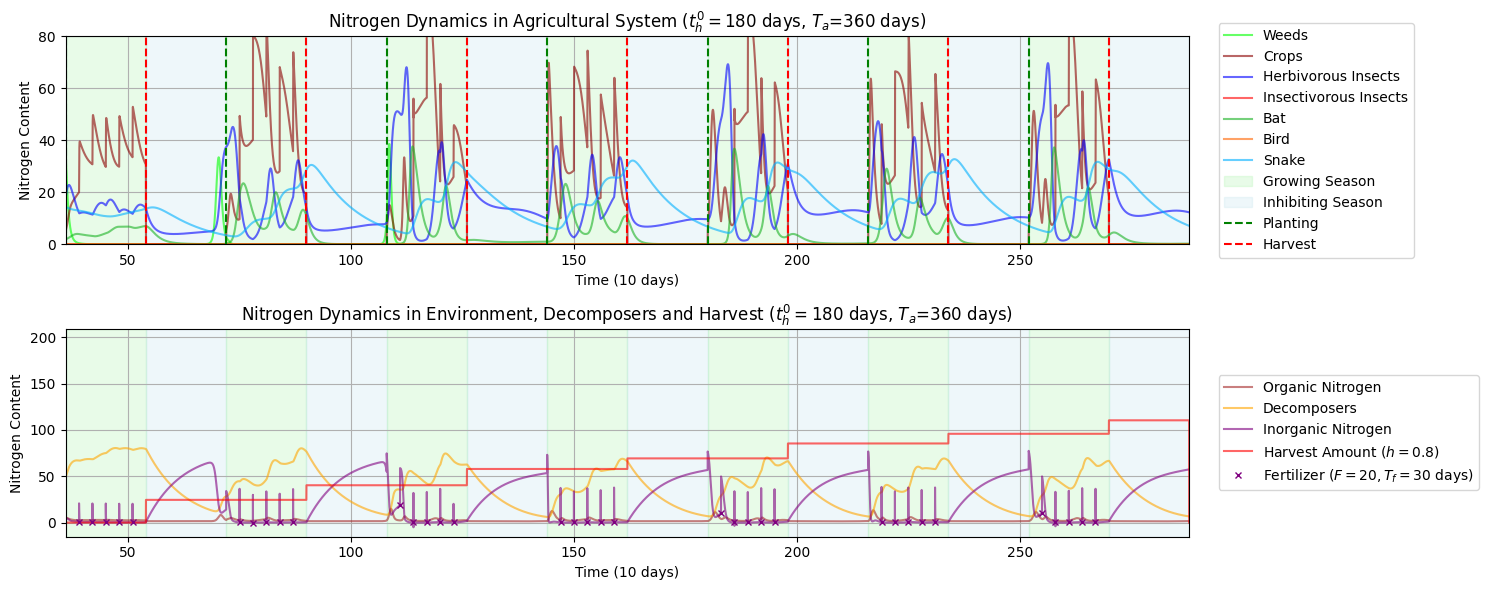

In [39]:
# 无除草剂，考虑蝙蝠传粉
import numpy as np
import matplotlib.pyplot as plt

# New parameters
# Agricultural parameters
T_a = 36  # agricultural cycle
t_h_0 = 18  # initial harvest time
t_s_0 = 0  # initial planting time
S = 5     # seeding amount
h = 0.8    # harvest coefficient

# Chemical parameters
gamma_w_chem = 0.8    # herbicide effect
lambda_w = 0.06        # herbicide decay rate
T_w = 4000             # herbicide application period 除草周期
gamma_1_chem = 2   # pesticide effect
lambda_1 = 0.04        # pesticide decay rate 
T_1 = 3000            # pesticide application period 杀虫周期

# Fertilizer parameters
F = 20               # fertilizer amount
T_f = 3            # fertilizer period
t_f_0 = 0           # initial fertilizer time

# Parameters for seasonal variation
T = 36  # period (12 months)
phi = 0  # phase shift
r_w_0 = 0.07  # baseline growth rate of weeds
r_w_season = 0.035  # seasonal amplitude for weeds
r_c_0 = 0.05  # baseline growth rate of crops
r_c_season = 0.02  # seasonal amplitude for crops
r_bat = 0.2
gamma_1_0 = 0.02  # baseline death rate for primary consumers
gamma_1_season = 0.067  # seasonal amplitude for primary consumer death rate
gamma_w_0 = 0.067  # baseline death rate for weeds
gamma_w_season = 0.05  # seasonal amplitude for weed death rate
gamma_c_0 = 0.03  # baseline death rate for crops
gamma_c_season = 0.015  # seasonal amplitude for crop death rate

# Other parameters remain the same as before
gamma = np.array([gamma_1_0, 0.5, 0.3, 0.2, 0.1])  # initial death rates for consumers
alpha_w1 = 0.08
alpha_c1 = 0.04
alpha = np.array([0.05])
beta_w1 = 0.04
beta_c1 = 0.02
beta = np.array([0.04])
c_wc = 0.0002
c_cw = 0.0005
d = 0.2
delta = 0.12
gamma_D = 0.30


# Time parameters
t_max = 288
dt = 0.005
t = np.arange(0, t_max, dt)
n_steps = len(t)

prey_matrix = np.array([[0,1,1,1,0], [0,0,1,1,0], [0,0,0,0,1], [0,0,0,0,1], [0,0,0,0,0]])
alpha_matrix = np.array([[0, 0.04, 0.07 ,0.04 ,0], [0 ,0 ,0.05 ,0.03 ,0], [0, 0, 0, 0, 0.03], [0, 0, 0, 0, 0.03], [0,0,0,0,0]])
beta_matrix = np.array([[0, 0.03, 0.05 ,0.03 ,0], [0 ,0 ,0.04 ,0.02 ,0], [0, 0, 0, 0, 0.02], [0, 0, 0, 0, 0.02], [0,0,0,0,0]])


# Initialize arrays (same as before)
N_w = np.zeros(n_steps)
N_c = np.zeros(n_steps)
N = np.zeros((5, n_steps))
N_org = np.zeros(n_steps)
N_D = np.zeros(n_steps)
N_inorg = np.zeros(n_steps)
# Initialize arrays
harvest = np.zeros(n_steps)  # Store harvest amount at each time point
last_harvest_time = -float('inf')  # Track the last harvest time
have_harvest = np.zeros(n_steps)  # Store harvest at each time point

# Initial conditions (same as before)
N_w[0] = 10
N_c[0] = 15
N[:, 0] = [4, 4, 4, 4, 3]
N_org[0] = 5
N_D[0] = 150
N_inorg[0] = 20

# Define time-varying parameter functions
def r_w(t):
    return r_w_0 + r_w_season * np.sin(2*np.pi*t/T + phi)

def r_c(t,n):
    return r_c_0 + r_bat * n + r_c_season * np.sin(2*np.pi*t/T + phi)

def gamma_c(t):
    return gamma_c_0 + gamma_c_season * np.sin(2*np.pi*t/T + phi + np.pi)


def gamma_w(t):
    n_w = int(t/T_w)  # Current herbicide cycle
    if(N_c[i] > 0):
        return (gamma_w_0 + 
                gamma_w_chem * np.exp(-lambda_w * (t - T_w*n_w)) +
                gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi))
    else:
        return gamma_w_0 + gamma_w_season * np.sin(2*np.pi*t/T + phi + np.pi)

def gamma_1(t):
    n_1 = int(t/T_1)  # Current pesticide cycle
    if(N_c[i] > 0):
        return (gamma_1_0 + 
            gamma_1_chem * np.exp(-lambda_1 * (t - T_1*n_1)) +
            gamma_1_season * np.sin(2*np.pi*t/T + phi))
    else:
        return gamma_1_0 + gamma_1_season * np.sin(2*np.pi*t/T + phi)



# Modified simulation loop
for i in range(n_steps-1):
    n_a = int(t[i]/T_a)  # Current agricultural cycle

    # Update time-varying parameters
    current_gamma = np.array([gamma_1(t[i]), gamma[1], gamma[2], gamma[3], gamma[4]])
    
    # Producers (Weeds and Crops)
    N_w[i+1] = N_w[i] + dt * (r_w(t[i]) * N_inorg[i] * N_w[i] - gamma_w(t[i]) * N_w[i] - 
                              alpha_w1 * N_w[i] * N[0,i] - c_cw * N_c[i] * N_w[i])
    
    N_c[i+1] = N_c[i] + dt * (r_c(t[i],N[2,i]) * N_inorg[i] * N_c[i] - gamma_c(t[i]) * N_c[i] - 
                              alpha_c1 * N_c[i] * N[0,i] - c_wc * N_w[i] * N_c[i])
    
    # Calculate predation and consumption terms using matrices
    for j in range(5):  # j is predator
        # Calculate predation loss
        predation_loss = np.sum((prey_matrix[j,:] * alpha_matrix[j,:]) * N[:,i]) * N[j,i]
        # Calculate consumption gain
        consumption_gain = np.sum((prey_matrix[:,j] * beta_matrix[:,j]) * N[:,i]) * N[j,i]
        # Update population
        N[j,i+1] = N[j,i] + dt * (-predation_loss + consumption_gain - current_gamma[j] * N[j,i])

    N[0,i+1] += dt * (beta_w1 * N_w[i] * N[0,i] + beta_c1 * N_c[i] * N[0,i])
    

    # Organic nitrogen
    producer_mortality = gamma_w(t[i])* N_w[i] + gamma_c(t[i]) * N_c[i]
    consumer_mortality = sum(current_gamma[j] * N[j,i] for j in range(2))
    unconsumed_prey = (alpha_w1 - beta_w1) * N_w[i] * N[0,i] + (alpha_c1 - beta_c1) * N_c[i] * N[0,i] + \
                     (alpha[0] - beta[0]) * N[0,i] * N[1,i]
    competition_loss = (c_wc + c_cw) * N_w[i] * N_c[i]
    
    N_org[i+1] = N_org[i] + dt * (unconsumed_prey + producer_mortality + consumer_mortality + 
                                  competition_loss + gamma_D * N_D[i] - d * N_D[i] * N_org[i])
    
    # Decomposers and Inorganic nitrogen (same as before)
    N_D[i+1] = N_D[i] + dt * (delta * N_D[i] * N_org[i] - gamma_D * N_D[i])
    N_inorg[i+1] = N_inorg[i] + dt * ((d - delta) * N_D[i] * N_org[i] - 
                                      r_w(t[i]) * N_inorg[i] * N_w[i] - r_c(t[i],N[2,i]) * N_inorg[i] * N_c[i])
    
 # Add fertilizer
    n_f = int(t[i]/T_f)
    if abs(t[i] - (t_f_0 + T_f*n_f)) < dt:
        if (N_c[i] > 0):
            N_inorg[i+1] += F


    # Harvest time
    if abs(t[i] - (t_h_0 + T_a*n_a)) < dt and N_c[i] > 0:
        harvest[i] = h * N_c[i+1] + harvest[i-1] # Store the harvest amount
        N_c[i+1] = 0  # Remove crops after harvest
    else:
        harvest[i] = harvest[i-1]  # Maintain harvest amount after harvest time

    if n_a == 0:
        harvest[i] = 0

    # Planting time with smooth transition
    if (abs(t[i] - (t_s_0 + T_a*n_a)) < dt):
        # Only plant if there are no crops
        if N_c[i] < 0.1:  # Small threshold to check if field is empty
            N_c[i+1] = S
        else:
            N_c[i+1] = N_c[i]  # Maintain current crop level if already planted
        

# Plot results
plt.figure(figsize=(15, 6))

# First subplot: Population dynamics
plt.subplot(2, 1, 1)
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.ylim(0, 80)  # Limit x-axis to actual data range
plt.plot(t, N_w, label='Weeds', color='lime', alpha=0.6)
plt.plot(t, N_c, label='Crops', color='darkred', alpha=0.6)
plt.plot(t, N[0], label='Herbivorous Insects', color='blue', alpha=0.6)
plt.plot(t, N[1], label='Insectivorous Insects', color='red', alpha=0.6)
plt.plot(t, N[2], label='Bat', color='#1ab223', alpha=0.6)
plt.plot(t, N[3], label='Bird', color='#ff6500', alpha=0.6)
plt.plot(t, N[4], label='Snake', color='#00b0ff', alpha=0.6)

# Add markers for herbicide application
for i in range(int(t_max/T_w)):
    if N_c[int(i*T_w/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_w, N_w[int(i*T_w/dt)], '^', color='lime', markersize=5, 
                label='Herbicide' if i==0 else "")

# Add markers for pesticide application
for i in range(int(t_max/T_1)):
    if N_c[int(i*T_1/dt)] > 0:  # Only show when crops exist
        plt.plot(i*T_1, N[0,int(i*T_1/dt)], 'x', color='blue', markersize=5, 
                label='Pesticide' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2, 
                label='Growing Season' if i==0 else "")
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2, 
                label='Inhibiting Season' if i==0 else "")
                
# Add markers for agricultural operations
for i in range(int(t_max/T_a)):
    # Planting time markers
    plt.axvline(x=t_s_0 + i*T_a, color='green', linestyle='--', 
                label='Planting' if i==0 else "")
    # Harvest time markers
    plt.axvline(x=t_h_0 + i*T_a, color='red', linestyle='--', 
                label='Harvest' if i==0 else "")

# Enable mathtext
plt.rcParams['mathtext.fontset'] = 'dejavusans'
# Plot and set title with mathtext
plt.title(r'Nitrogen Dynamics in Agricultural System ($t_h^{0}=180$ days, $T_a$=360 days)')

# plt.title('Nitrogen Dynamics in Agricultural System ()')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)

# Second subplot: Nitrogen dynamics
plt.subplot(2, 1, 2)
plt.xlim(36, t_max)  # Limit x-axis to actual data range
plt.plot(t, N_org, label='Organic Nitrogen', color='brown', alpha=0.6)
plt.plot(t, N_D, label='Decomposers', color='orange', alpha=0.6)
plt.plot(t, N_inorg, label='Inorganic Nitrogen', color='purple', alpha=0.6)
plt.plot(t, harvest, label=r'Harvest Amount ($h = 0.8$)', color='red', alpha=0.6)

# Add markers for fertilizer application
for i in range(int(t_max/T_f)):
    if N_c[int(i*T_f/dt)] > 0:  # Only show markers when crops exist
        plt.plot(i*T_f, N_inorg[int(i*T_f/dt)], 'x', color='purple', markersize=5, 
                label=r'Fertilizer ($F = 20, T_f = 30$ days)' if i==0 else "")

# Add background shading for seasons
for i in range(int(t_max/T)):
    plt.axvspan(i*T, i*T + T/2, color='lightgreen', alpha=0.2)
    plt.axvspan(i*T + T/2, i*T + T, color='lightblue', alpha=0.2)

plt.title(r'Nitrogen Dynamics in Environment, Decomposers and Harvest ($t_h^{0}=180$ days, $T_a$=360 days)')
plt.xlabel('Time (10 days)')
plt.ylabel('Nitrogen Content')
plt.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.grid(True)

plt.tight_layout()
plt.show()


In [51]:
print(harvest)

[  0.           0.           0.         ... 480.52704576 480.52704576
   0.        ]


In [52]:
480.527/(7*20*6)

0.5720559523809524